In [1]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)


hide_toggle()

In [2]:
#zwykła konwolucyjna sieć - obrazek czas x czestosc, kanały RGB - elektrody - przetestować
#CONV2D, minpooling potem, dense (f-cja aktywacji softmax) - wyjscie to p-stwo wyjscia z klas
#punkt początkowy j.w.
#filtr dla sieci - dłuższy w czasie (np. 7,11), najwyżej dociać
#zbiory uczące - potem będziemy składać sieci
#zbiory - 2 sposoby jak je budować (od Mateusza)
#widmo - spr do jakiej częstości obciąć (z tego co wychodzi z abs hilberta), 6 razy mniej (?)
#kilka próbek od kilku pacjentów

#wyćwiczone na wszystkich - wyzerować któreś i tak sprawdzić (pasmo częstowściowe)
hide_toggle()

In [3]:
''' 25 na 5 foldów - 5x5 średnie acc, auc
    8 walidacyjnych zostaje
    5 różnych modeli - dla każddego z osobna walidacja
    jesli więcej niż 3 modele na daną klase - zaklasyfikowany - policzyć accuracy,
    wykresy acc w czasie i loss w czasie dla każdej z 5 (25 na 5 foldów) modeli (w każdej iteracji),
    sprawadź dla paru batch size jak sie zachowują wykresy,
    '''
hide_toggle()

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, AveragePooling2D, Flatten, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from typing import Iterable, Union
from numpy.random import seed
seed(2020)
from tensorflow import set_random_seed
set_random_seed(2020)

hide_toggle()

In [9]:
def get_training(X, y, combinations, pic_mode):
    X_train = np.concatenate([X[ind] for ind in combinations], axis = 1)
    X_train = np.einsum(pic_mode, X_train)
    y_train = np.concatenate([y[ind] for ind in combinations])
    y_train = to_categorical(y_train).astype(int)
    return X_train, y_train

def get_test(X, y, ind, pic_mode):
    X_test = np.einsum(pic_mode, X[ind])
    y_test = to_categorical(y[ind]).astype(int)
    return X_test, y_test



In [3]:
def evaluate(model, X_val: Iterable, y_val: Iterable, verbose = 1):
    # Generate generalization metrics
    score = model.evaluate(X_val, y_val, verbose=0)
    if verbose:
        print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')
    return score

def plot_history(history, loss_fun: str):
    # Plot history: Categorical crossentropy & Accuracy
    plt.figure(figsize=(12,8))
    plt.plot(history.history['loss'], label=loss_fun + '(training data)')
    plt.plot(history.history['val_loss'], label=loss_fun + '(validation data)')
    plt.plot(history.history['acc'], label='Accuracy (training data)')
    plt.plot(history.history['val_acc'], label='Accuracy (validation data)')
    plt.title('Model performance')
    plt.ylabel('Loss value')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper left")
    plt.show()

In [16]:
def create_model(sample_shape: Iterable,
                 no_classes: int, kernel: Iterable,
                 loss_fun = 'binary_crossentropy'):
    model = Sequential()
    model.add(Conv2D(64, kernel_size = kernel,input_shape=sample_shape, activation='relu', data_format = 'channels_last'))
    model.add(AveragePooling2D(kernel))
    model.add(Dropout(0.4))
    model.add(Dense(64, activation='softmax'))
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(no_classes, activation='softmax'))
    model.compile(loss=loss_fun, optimizer='adam', metrics=['accuracy'])
    return model

def create_model_LSTM(sample_shape: Iterable,
                 no_classes: int, kernel: Iterable,
                 loss_fun = 'binary_crossentropy'):
    model = Sequential()
    model.add(ConvLSTM2D(filters = 15, kernel_size = kernel, activation='tanh', dropout = 0.4, return_sequences = True, input_shape = sample_shape,data_format='channels_last',recurrent_activation='hard_sigmoid'))
    # model.add(BatchNormalization())
    # model.add(SpatialDropout3D(1))
    # model.add(Dense(10, activation='tanh'))
    # model.add(ConvLSTM2D(filters = 20, kernel_size = (1,1), activation='tanh', dropout = 0.5, return_sequences = True))
    # model.add(BatchNormalization())
    model.add(Flatten())
    # model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(no_classes, activation='softmax'))
    model.compile(loss=loss_fun, optimizer='adam', metrics=['accuracy'])
    return model

def fit(model, X_train: Iterable, y_train: Iterable, 
                      X_test: Iterable, y_test: Iterable,
                      batch_size: int, no_epochs: int, 
                      verbosity = 1):
    
    # Fit data to model
    history = model.fit(X_train, y_train,
                batch_size=batch_size,
                epochs=no_epochs,
                verbose=verbosity,
                validation_data=(X_test, y_test))
    return model, history

# Loading data

In [5]:
class_no8 = np.load('class_no8.npy')
data_no8 = np.load('data_no8.npy')


class_no13 = np.load('class_no13.npy')
data_no13 = np.load('data_no13.npy')

class_no18 = np.load('class_no18.npy')
data_no18 = np.load('data_no18.npy')

class_no23 = np.load('class_no23.npy')
data_no23 = np.load('data_no23.npy')

class_no28 = np.load('class_no28.npy')
data_no28 = np.load('data_no28.npy')

class_no33 = np.load('class_no33.npy')
data_no33 = np.load('data_no33.npy')

hide_toggle()

## Picture options - time x freq bands or time x channels

In [6]:
freq_bands = 'ijkl->jlik'
channels = 'ijkl->jlki'

### Validation dataset

In [61]:
X_validation = np.einsum(freq_bands,data_no8)
y_validation = to_categorical(class_no8).astype(int)

## Prepared combinations

In [50]:
X = {1 : data_no13, 2: data_no18, 3: data_no23, 4: data_no28, 5: data_no33}
y = {1 : class_no13, 2: class_no18, 3: class_no23, 4: class_no28, 5: class_no33}
combinations_train = ((1,2,3,4),
                      (1,2,3,5),
                      (1,2,4,5),
                      (1,3,4,5),
                      (2,3,4,5))

combinations_test = (5, 4, 3, 2, 1)

### Params

In [56]:
batch_size = 200
no_epochs = 15
verbosity = 1
loss_fun = 'categorical_crossentropy'

## Datasets

In [57]:
combination = 1
X_train, y_train = get_training(X, y, combinations_train[combination], channels)
X_test, y_test = get_test(X, y, combinations_test[combination], channels)
sample_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])

## Learning

In [58]:
bands_i = [0,1,2,3]
sample_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3]-1)
"Creating model"
model = create_model(sample_shape, 2, (7,3))

"Fitting model to data"
fitted_model, hist = fit(model, X_train[:,:,:,bands_i], y_train, X_test[:,:,:,bands_i], y_test, 
            batch_size, no_epochs)

Train on 18144 samples, validate on 4618 samples
Epoch 1/15
18144/18144 [==============================] - 7s 361us/sample - loss: 0.6937 - acc: 0.5029 - val_loss: 0.6929 - val_acc: 0.5006
Epoch 2/15
18144/18144 [==============================] - 6s 327us/sample - loss: 0.6903 - acc: 0.5323 - val_loss: 0.6901 - val_acc: 0.5314
Epoch 3/15
18144/18144 [==============================] - 6s 326us/sample - loss: 0.6882 - acc: 0.5378 - val_loss: 0.6882 - val_acc: 0.5435
Epoch 4/15
18144/18144 [==============================] - 6s 325us/sample - loss: 0.6859 - acc: 0.5518 - val_loss: 0.6868 - val_acc: 0.5489
Epoch 5/15
18144/18144 [==============================] - 6s 327us/sample - loss: 0.6855 - acc: 0.5497 - val_loss: 0.6861 - val_acc: 0.5435
Epoch 6/15
18144/18144 [==============================] - 6s 327us/sample - loss: 0.6828 - acc: 0.5624 - val_loss: 0.6847 - val_acc: 0.5585
Epoch 7/15
18144/18144 [==============================] - 6s 326us/sample - loss: 0.6834 - acc: 0.5633 - val_lo

## Evaluating

Test loss: 0.6836381687312889 / Test accuracy: 0.556897759437561


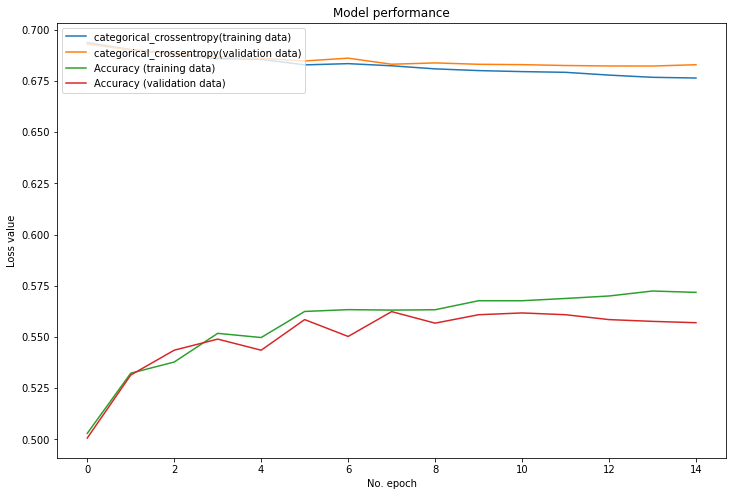

In [59]:
"Getting validation and loss score"
score = evaluate(fitted_model, X_validation[:,:,:,bands_i], y_validation)

"Plotting history"
plot_history(hist, loss_fun)

## Collecting votes

In [62]:
X_validation = np.einsum(freq_bands,data_no8)
y_validation = to_categorical(class_no8).astype(int)

In [65]:
batch_size = 200
no_epochs = 15

trials = y_validation.shape[0]
pred = np.zeros((5,trials))

for i in range(5):
    X_train, y_train = get_training(X, y, combinations_train[i], freq_bands)
    X_test, y_test = get_test(X, y, combinations_test[i], freq_bands)
    sample_shape = (X_train.shape[1], X_train.shape[2]-1, X_train.shape[3])
    
    model = create_model(sample_shape, 2, (7,1))
    
    fitted_model, _ = fit(model, X_train[:,:,bands_i,:], y_train, X_test[:,:,bands_i,:], y_test, 
                batch_size, no_epochs, verbosity = 0)
    
    pred[i] = fitted_model.predict_classes(X_validation[:,:,bands_i,:])
    print(i)
votes = np.sum(pred, axis = 0)
votes[votes<=2] = 0
votes[votes>=3] = 1
score = len(votes[class_no8==votes])
acc = score/trials
print(acc)

0
1
2
3
4
0.5736444749485243
